# Analysis of Video and Image Data for cropping and texture features
Author(s): Miguel Xochicale @mxochicale    
Contributor(s): Sujon Hekim

## History
* 17th May 2022: Add prototype

## Summary


### How to run the notebook
1. Go to repository path: `$HOME/repositories/`
Open repo in pycharm and in the terminal type:
```
git checkout main # or the branch
git pull # to bring a local branch up-to-date with its remote version
```

2. Launch Notebook server. Go to you repository path: cd $HOME/repositories/ and type in the pycharm terminal:
```
mamba activate *VE 
jupyter notebook --browser=firefox
```
which will open your web-browser.

## References 
1. https://stackoverflow.com/questions/45704999/how-to-convert-vector-wrapped-as-string-to-numpy-array-in-pandas-dataframe
2. https://github.com/YuxinZhaozyx/pytorch-VideoDataset/blob/master/datasets.py (Future work)
3. https://stackoverflow.com/questions/65446464/how-to-convert-a-video-in-numpy-array
4. https://matplotlib.org/stable/gallery/specialty_plots/mri_with_eeg.html#sphx-glr-gallery-specialty-plots-mri-with-eeg-py 
5. https://www.researchgate.net/publication/326881329_Medical_image_security_enhancement_using_two_dimensional_chaotic_mapping_optimized_by_self-adaptive_grey_wolf_algorithm 

    

## Setting imports and datasets paths

In [1]:
from scripts.utils.utils import video_to_tensor, compute_texture_array_and_plot
from scripts.utils.utils import get_and_plot_data_frame_of_texture_analysis
from scripts.utils.utils import get_and_plot_imu_data_analysis

import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import skimage
from typing import Tuple, List

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
REPOSITORY_PATH='repositories/in2research2023'

###########################
###SET DATA_PATH 
# DATA_PATH='scripts/sensor-fusion'
DATA_PATH='repositories/datasets/in2research2023/Thu-27-Jul-2023'


FULL_REPO_DATA_PATH = HOME_PATH +'/' + DATA_PATH
print(FULL_REPO_DATA_PATH)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'pandas Version: {pd.__version__}')
print(f'numpy Version: {np.__version__}')
print(f'cv2 Version: {cv2.__version__}')
print(f'skimage Version: {skimage.__version__}')

# ###########################
# ### experiments_13-Jul-2023
# AVI_FILE_01 = 'test01.avi'
# CSV_FILE_01 = 'test01.avi.csv'
# FULL_PATH_AND_AVI_FILE_01 = os.path.join(FULL_REPO_DATA_PATH , AVI_FILE_01)
# FULL_PATH_AND_CSV_FILE_01 = os.path.join(FULL_REPO_DATA_PATH , CSV_FILE_01)
# print(f'FULL_REPO_DATA_PATH: {FULL_REPO_DATA_PATH}')
# print(f'FULL_PATH_AND_CSV_FILE: {FULL_PATH_AND_CSV_FILE_01}')
# print(f'FULL_PATH_AND_AVI_FILE: {FULL_PATH_AND_AVI_FILE_01}')

/home/mxochicale/repositories/datasets/in2research2023/Thu-27-Jul-2023
PyTorch Version: 2.0.0.post200
pandas Version: 2.0.3
numpy Version: 1.25.1
cv2 Version: 4.8.0
skimage Version: 0.21.0


# Reading video and plotting frames

In [10]:
FULL_PATH_AND_AVI_FILE = os.path.join(FULL_REPO_DATA_PATH, 'participant01/participant01-test04.avi')
FULL_PATH_AND_CSV_FILE = os.path.join(FULL_REPO_DATA_PATH, 'participant01/participant01-test04.avi.csv')



start_frame_number = 000
end_frame_number = 900
total_number_of_frames = end_frame_number - start_frame_number


video, frames_timestam = video_to_tensor(FULL_PATH_AND_AVI_FILE, start_frame_number, end_frame_number)

num_frames, height, width = video.shape
print(f'num_frames: {num_frames}')
print(f'height: {height}')
print(f'width: {width}')


  
  
  VIDEO_FEATURES
    video_name=/home/mxochicale/repositories/datasets/in2research2023/Thu-27-Jul-2023/participant01/participant01-test04.avi
    Frame_height=480, frame_width=640 fps=120 nframes=7923 
  
  
num_frames: 899
height: 480
width: 640


# Generating texture_analysis_array and plotting frames and histograms

frame_i: 0, timestamp 00:00:0.000


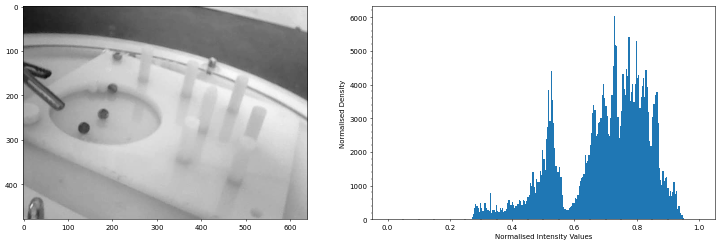

frame_i: 400, timestamp 00:03:333.333


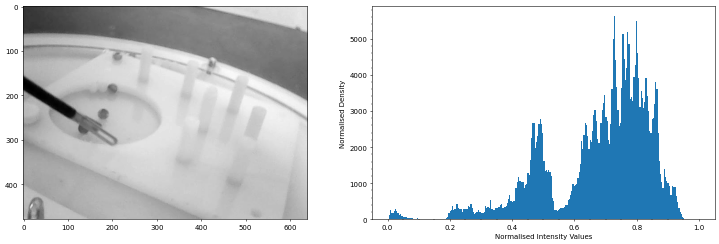

frame_i: 800, timestamp 00:06:666.667


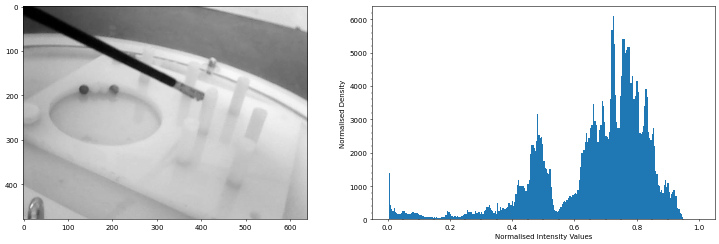

In [3]:
display_factor = 400    
texture_analysis_array = compute_texture_array_and_plot(video, frames_timestam, display_factor)


# Plotting texture analysis of all frames in the video

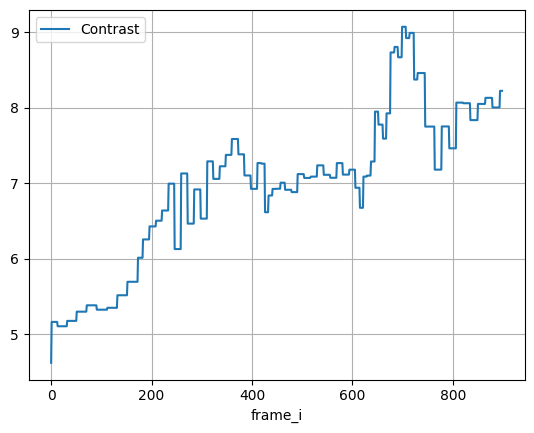

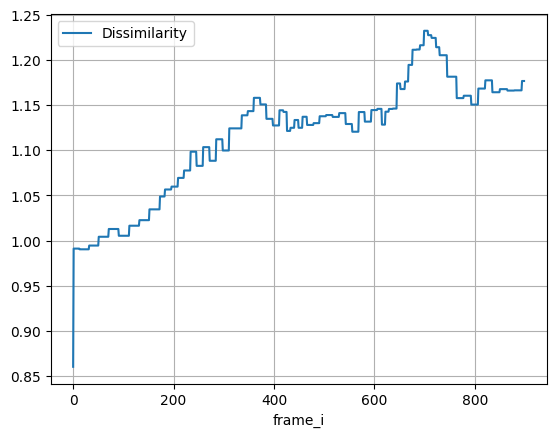

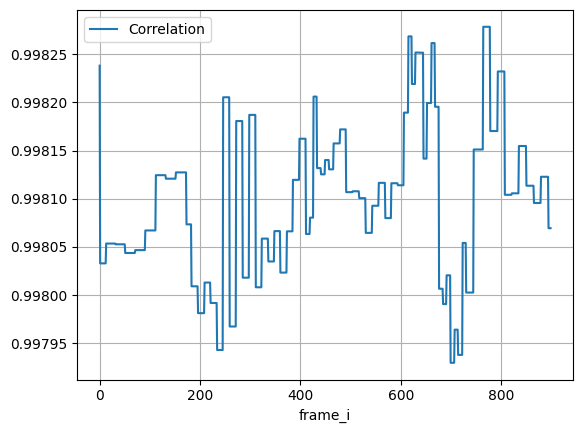

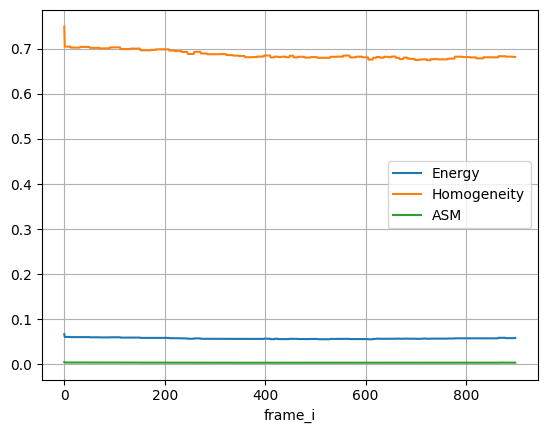

In [4]:

df_texture_analysis = get_and_plot_data_frame_of_texture_analysis(texture_analysis_array, total_number_of_frames)


In [5]:
print(df_texture_analysis)


     frame_i  Contrast  Correlation  Dissimilarity    Energy  Homogeneity  \
0          0  4.623543     0.998238       0.860221  0.066374     0.749130   
1          1  5.164254     0.998033       0.991047  0.060407     0.705082   
2          2  5.164254     0.998033       0.991047  0.060407     0.705082   
3          3  5.164254     0.998033       0.991047  0.060407     0.705082   
4          4  5.164254     0.998033       0.991047  0.060407     0.705082   
..       ...       ...          ...            ...       ...          ...   
894      894  8.221518     0.998069       1.176591  0.057997     0.682236   
895      895  8.221518     0.998069       1.176591  0.057997     0.682236   
896      896  8.221518     0.998069       1.176591  0.057997     0.682236   
897      897  8.221518     0.998069       1.176591  0.057997     0.682236   
898      898  8.221518     0.998069       1.176591  0.057997     0.682236   

          ASM  
0    0.004406  
1    0.003649  
2    0.003649  
3    0.0036

## Reading and ploting csv files

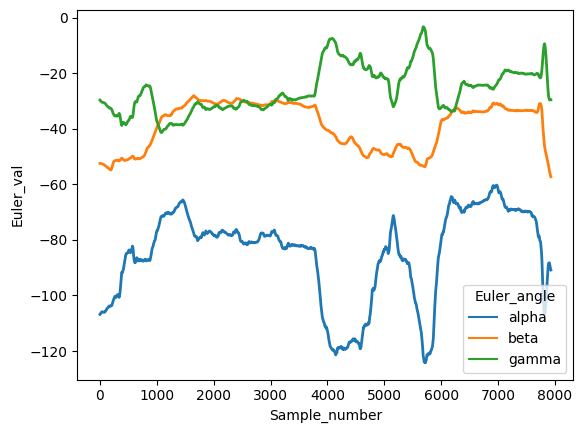

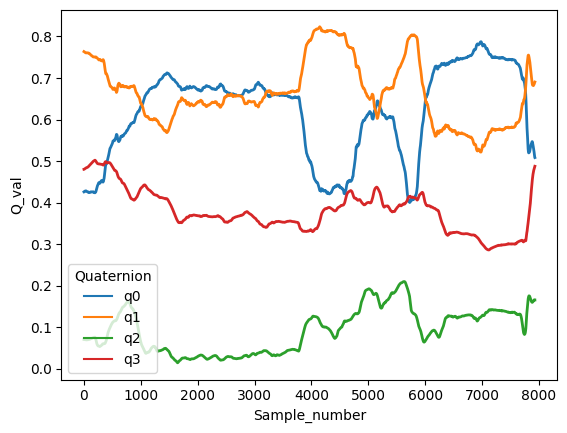

In [6]:
    df, ndf, nqdf = get_and_plot_imu_data_analysis(FULL_PATH_AND_CSV_FILE)
    

In [7]:
ndf

,Sample_number,Euler_angle,Euler_val
0,0,alpha,-106.816208
1,1,alpha,-106.809685
2,2,alpha,-106.782059
3,3,alpha,-106.753441
4,4,alpha,-106.720901
...,...,...,...
23782,7924,gamma,-29.572041
23783,7925,gamma,-29.582962
23784,7926,gamma,-29.605570
23785,7927,gamma,-29.622272


In [8]:
nqdf

,Sample_number,Quaternion,Q_val
0,0,q0,0.425897
1,1,q0,0.425981
2,2,q0,0.426065
3,3,q0,0.426155
4,4,q0,0.426259
...,...,...,...
31711,7924,q3,0.486186
31712,7925,q3,0.486642
31713,7926,q3,0.487051
31714,7927,q3,0.487375


In [9]:
df

,Sample_number,epoch machine time (ns),Timestamp for frame capture.read (ns),Timestamp LPMSB2 (s),Quaternions_LPMSB2,Euler_LPMSB2,A,B,C,q0,q1,q2,q3
0,0,1690462168848654049,1690462168849621185,701.245,"[0.42589715123176575, 0.7636324167251587, 0.07...","[-106.81620788574219, -52.48710632324219, -29....",-106.816208,-52.487106,-29.680767,0.425897,0.763632,0.070353,0.480133
1,1,1690462168881100403,1690462168849621185,701.250,"[0.42598122358322144, 0.7636178731918335, 0.07...","[-106.80968475341797, -52.4804573059082, -29.6...",-106.809685,-52.480457,-29.677153,0.425981,0.763618,0.070369,0.480079
2,2,1690462168888272100,1690462168849621185,701.255,"[0.4260654151439667, 0.7635247707366943, 0.070...","[-106.78205871582031, -52.48259735107422, -29....",-106.782059,-52.482597,-29.699024,0.426065,0.763525,0.070350,0.480155
3,3,1690462168893584828,1690462168849621185,701.260,"[0.4261549711227417, 0.7634265422821045, 0.070...","[-106.7534408569336, -52.48542785644531, -29.7...",-106.753441,-52.485428,-29.720583,0.426155,0.763427,0.070342,0.480233
4,4,1690462168899778092,1690462168849621185,701.265,"[0.42625853419303894, 0.7633144855499268, 0.07...","[-106.72090148925781, -52.48866653442383, -29....",-106.720901,-52.488667,-29.744629,0.426259,0.763314,0.070335,0.480320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7924,7924,1690462246398952313,1690462246400644878,740.865,"[0.5104851126670837, 0.6896628737449646, 0.165...","[-90.63880920410156, -57.09675598144531, -29.5...",-90.638809,-57.096756,-29.572041,0.510485,0.689663,0.165510,0.486186
7925,7925,1690462246415043655,1690462246400644878,740.870,"[0.5096790790557861, 0.6899437308311462, 0.165...","[-90.71991729736328, -57.160953521728516, -29....",-90.719917,-57.160954,-29.582962,0.509679,0.689944,0.165483,0.486642
7926,7926,1690462246429130444,1690462246400644878,740.875,"[0.5090813636779785, 0.6900993585586548, 0.165...","[-90.76563262939453, -57.2144889831543, -29.60...",-90.765633,-57.214489,-29.605570,0.509081,0.690099,0.165472,0.487051
7927,7927,1690462246442054418,1690462246400644878,740.880,"[0.5086487531661987, 0.6901741027832031, 0.165...","[-90.7928466796875, -57.26122283935547, -29.62...",-90.792847,-57.261223,-29.622272,0.508649,0.690174,0.165534,0.487375
